# Task 2

Program jest mniej więcej taki sam jak w zadaniu pierwszym z kilkoma różnicami

## Wczytanie bibliotek i plot_graphs

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Edycja danych wejściowych


w drugiej kolumnie datasetu zamiast tensora z 0 lub 1 jest tensor z trójką (1, 0, 0), (0, 1, 0) lub (0, 0, 1)


In [ ]:
tags = open("/content/training_set_clean_only_tags.txt", encoding='utf8')
texts = open("/content/training_set_clean_only_text.txt", encoding='utf8')

def czydobre(i):
  if (int(i)== 0):
    return (1, 0, 0)
  elif (int(i)==1):
    return (0, 1, 0)
  else:
    return (0, 0 ,1)

dataset1 = tf.data.Dataset.from_tensor_slices(texts.readlines())
dataset2 = tf.data.Dataset.from_tensor_slices([ czydobre(x) for x in tags.readlines()])

texts.close()
tags.close()

dataset = tf.data.Dataset.zip((dataset1, dataset2))
dataset


tags = open("/content/test_set_only_tags.txt", encoding='utf8')
texts = open("/content/test_set_only_text.txt", encoding='utf8')



dataset1_test = tf.data.Dataset.from_tensor_slices(texts.readlines())
dataset2_test = tf.data.Dataset.from_tensor_slices([ czydobre(x) for x in tags.readlines()])

texts.close()
tags.close()

dataset_test = tf.data.Dataset.zip((dataset1_test, dataset2_test))


In [ ]:
for example, label in dataset.take(5):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'Dla mnie faworytem do tytu\xc5\x82u b\xc4\x99dzie Cracovia. Zobaczymy, czy typ si\xc4\x99 sprawdzi.\n'
label:  [1 0 0]
text:  b'@anonymized_account @anonymized_account Brawo ty Daria kibic ma by\xc4\x87 na dobre i z\xc5\x82e\n'
label:  [1 0 0]
text:  b'@anonymized_account @anonymized_account Super, polski premier sk\xc5\x82ada kwiaty na grobach kolaborant\xc3\xb3w. Ale doczekali\xc5\x9bmy czas\xc3\xb3w.\n'
label:  [1 0 0]
text:  b'@anonymized_account @anonymized_account Musi. Innej drogi nie mamy.\n'
label:  [1 0 0]
text:  b'Odrzut natychmiastowy, kwa\xc5\x9bna mina, mam problem\n'
label:  [1 0 0]


In [ ]:
train_dataset = dataset
test_dataset = dataset_test

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Z ca\xc5\x82ym szacunkiem zayn, ale wzi\xc4\x85\xc5\x82by\xc5\x9b si\xc4\x99 za wydanie z2, a nie promowanie plecak\xc3\xb3w XD\n'
 b'@anonymized_account masz na my\xc5\x9bli Mateusza Taudula ?:) @anonymized_account\n'
 b'@anonymized_account Masz, \xc5\xbceby nie by\xc5\x82o, \xc5\xbce bez lajka \xf0\x9f\x98\x84\n']

labels:  [[1 0 0]
 [1 0 0]
 [1 0 0]]


## Encoder

Encoder taki sam

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'anonymizedaccount', 'nie', 'to', 'w', 'na', 'i',
       'się', 'z', 'a', 'że', 'jak', 'jest', 'do', 'ale', 'co', 'o',
       'tak', 'rt'], dtype='<U17')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  9, 663,   1,   1,  15,   1,   8,  20,   1,   1,  10,   3,   1,
          1,  64,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  77,   6, 425,   1,   1,   2,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  77,  57,   3,  46,  11,  70,   1, 382,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Z ca\xc5\x82ym szacunkiem zayn, ale wzi\xc4\x85\xc5\x82by\xc5\x9b si\xc4\x99 za wydanie z2, a nie promowanie plecak\xc3\xb3w XD\n'
Round-trip:  z całym [UNK] [UNK] ale [UNK] się za [UNK] [UNK] a nie [UNK] [UNK] xd          

Original:  b'@anonymized_account masz na my\xc5\x9bli Mateusza Taudula ?:) @anonymized_account\n'
Round-trip:  anonymizedaccount masz na myśli [UNK] [UNK] anonymizedaccount                  

Original:  b'@anonymized_account Masz, \xc5\xbceby nie by\xc5\x82o, \xc5\xbce bez lajka \xf0\x9f\x98\x84\n'
Round-trip:  anonymizedaccount masz żeby nie było że bez [UNK] 😄                



## Model

model różni się tym, że na końcu ma 3 neurony zamisat jednego


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Trenowanie modelu

Sieć uczy się wolniej ponieważ jest bardziej skomplikowana niż pierwsza

In [ ]:
history = model.fit(train_dataset, epochs=50,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/50
314/314 [==============================] - 17s 24ms/step - loss: 0.3943 - accuracy: 0.9037 - val_loss: 0.3234 - val_accuracy: 0.8708
Epoch 2/50
314/314 [==============================] - 6s 19ms/step - loss: 0.2521 - accuracy: 0.9152 - val_loss: 0.2974 - val_accuracy: 0.8708
Epoch 3/50
314/314 [==============================] - 6s 19ms/step - loss: 0.2408 - accuracy: 0.9152 - val_loss: 0.3026 - val_accuracy: 0.8708
Epoch 4/50
314/314 [==============================] - 6s 19ms/step - loss: 0.2327 - accuracy: 0.9152 - val_loss: 0.2901 - val_accuracy: 0.8708
Epoch 5/50
314/314 [==============================] - 6s 20ms/step - loss: 0.2314 - accuracy: 0.9152 - val_loss: 0.2936 - val_accuracy: 0.8708
Epoch 6/50
314/314 [==============================] - 6s 19ms/step - loss: 0.2261 - accuracy: 0.9152 - val_loss: 0.2930 - val_accuracy: 0.8708
Epoch 7/50
314/314 [==============================] - 6s 19ms/step - loss: 0.2218 - accuracy: 0.9152 - val_loss: 0.2854 - val_accuracy: 0.870

(0.0, 0.49666156284511087)

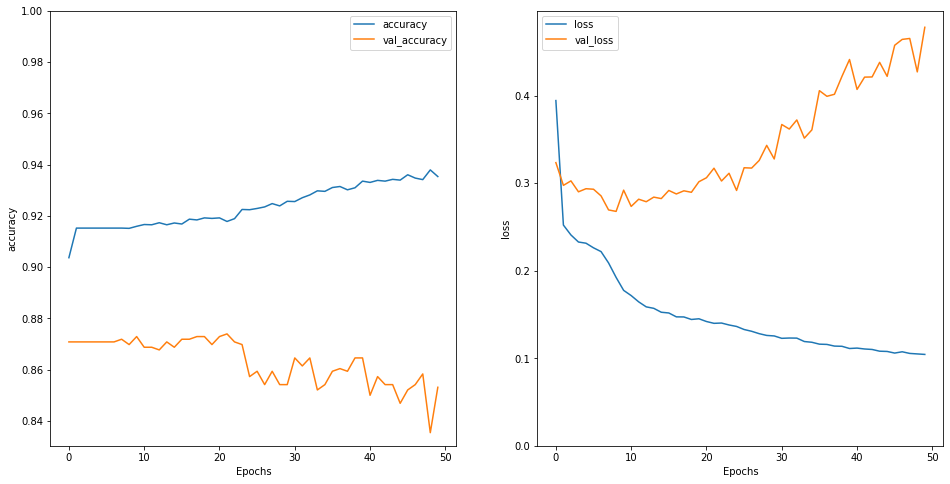

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plot_graphs
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)